# **Tech Challenge - Data Viz - 4ª Fase**

## **1 - Introdução**

- A análise visa realizar a previsão dos valores futuros de fechamento do período diário da IBOVESPA através de algoritmos de machine learning.

  ## **2 - 	Objetivo Geral**

Realizar a análise exploratória robusta em busca de aprimorar o entendimento dos dados, criar um modelo preditivo através de algoritmos de machine learning com dados da IBOVESPA para criar uma série temporal e prever diariamente o fechamento da base.

 E com base na análise demonstrar para o time de investimentos os seguintes pontos:
- O modelo com o storytelling, desde a captura do dado até a entrega do modelo.
- Justificar a técnica utilizada.
- Atingir uma acuracidade adequada (acima de 70%).

## **3 - Material e Ferramentas**

Embasando na robustez deste relatório, a base de dados utilizados nesta análise foi extraída da fonte do site da investing, sugerido para este trabalho com o período diário e com um intervalo de 20 anos assim atingindo uma maior acuracidade no modelo preditivo.

Para a análise foram usadas ferramentas de suma importância no cenário de análise de dados, tais como: Google Colab, Python.

## 4 - Importação dos dados

### 4.1 - Bibliotecas

In [10]:
# Instalação bibliotecas necessarias

%pip install requests beautifulsoup4 pandas
%pip install statsforecast
%pip install pmdarima
%pip install -U scikit-learn
%pip install plotly==5.24.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Importando bibliotecas necessarias
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


### 4.2 - Import base de dados

- Importando o DataSet direto da pagina do IPA

In [3]:
# URL da página do ipeadata
url = "http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view"

# Fazendo a requisição HTTP para a página
response = requests.get(url)

# Verificando o status da requisição
if response.status_code == 200:
    print("Conexão bem-sucedida!")
else:
    print(f"Erro ao acessar a página: {response.status_code}")

# Parseando o HTML com BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Buscando a tabela na página
table = soup.find("table", {"class": "dxgvTable"})  # Identifique a classe correta da tabela
if table:
    # Extraindo os dados da tabela
    rows = table.find_all("tr")
    data = []

    # Iterando pelas linhas da tabela
    for row in rows:
        cols = row.find_all("td")
        cols = [col.text.strip() for col in cols]
        if cols:  # Ignorar linhas vazias
            data.append(cols)

    # Convertendo os dados para um DataFrame do pandas
    columns = ["Data", "Preço","drop1","drop2","drop3","drop4"]  # Ajuste conforme as colunas da tabela
    df_dados = pd.DataFrame(data, columns=columns)

    # Deletando as colunas
    df_dados = df_dados.drop(columns=["drop1","drop2","drop3","drop4"])

    # Deletando as 3 primeiras linhs
    df_dados = df_dados.iloc[3:]

    # Exibindo os primeiros e ultimos registros
    print(df_dados)

    # Salvando os dados em um arquivo CSV
    df_dados.to_csv("dados_petroleo.csv", index=False)
    print("Dados salvos em 'dados_petroleo.csv'.")
else:
    print("Tabela não encontrada na página.")


Conexão bem-sucedida!
             Data  Preço
3      12/11/2024  72,56
4      11/11/2024  72,19
5      08/11/2024  74,04
6      07/11/2024  75,73
7      06/11/2024  76,52
...           ...    ...
11296  26/05/1987  18,63
11297  25/05/1987  18,60
11298  22/05/1987  18,55
11299  21/05/1987  18,45
11300  20/05/1987  18,63

[11298 rows x 2 columns]
Dados salvos em 'dados_petroleo.csv'.


In [4]:
df_dados

,Data,Preço
3,12/11/2024,"72,56"
4,11/11/2024,"72,19"
5,08/11/2024,"74,04"
6,07/11/2024,"75,73"
7,06/11/2024,"76,52"
...,...,...
11296,26/05/1987,"18,63"
11297,25/05/1987,"18,60"
11298,22/05/1987,"18,55"
11299,21/05/1987,"18,45"


In [62]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11298 entries, 3 to 11300
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    11298 non-null  object
 1   Preço   11298 non-null  object
dtypes: object(2)
memory usage: 176.7+ KB


## 5 - Analise exploratória  e Tratamento dos Dados

In [87]:
# Renomeando as colunas
df_ipea = df_dados.rename(columns={"Data": "data", "Preço": "preco"})

# Convertendo a coluna 'data' para o tipo datetime
df_ipea["data"] = pd.to_datetime(df_ipea["data"], format="%d/%m/%Y")

# Convertendo a coluna 'preco' para float
df_ipea['preco'] = df_ipea['preco'].str.replace(',', '.').astype(float)


In [88]:
df_ipea

,data,preco
3,2024-11-12,72.56
4,2024-11-11,72.19
5,2024-11-08,74.04
6,2024-11-07,75.73
7,2024-11-06,76.52
...,...,...
11296,1987-05-26,18.63
11297,1987-05-25,18.60
11298,1987-05-22,18.55
11299,1987-05-21,18.45


In [89]:
df_ipea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11298 entries, 3 to 11300
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    11298 non-null  datetime64[ns]
 1   preco   11298 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 176.7 KB


In [90]:
print("Quantidade de linhas e colunas: ", df_ipea.shape)

Quantidade de linhas e colunas:  (11298, 2)


In [91]:
print("Estatísticas descritivas: ")
df_ipea.describe()

Estatísticas descritivas: 


,data,preco
count,11298,11298.000000
mean,2006-10-21 08:07:38.842273024,53.323291
min,1987-05-20 00:00:00,9.100000
25%,1998-07-03 18:00:00,20.630000
50%,2007-05-30 12:00:00,48.920000
75%,2015-03-27 18:00:00,76.800000
max,2024-11-12 00:00:00,143.950000
std,NaN,33.159540


In [92]:
print("Valores Nulos: ")
df_ipea.isna().sum()

Valores Nulos: 


,0
data,0
preco,0


In [93]:
print("Valores Duplicados: ")
df_ipea.duplicated().sum()

Valores Duplicados: 


0

In [94]:
# Setando data como INDEX
df_ipea = df_ipea.set_index('data')

# Preenchendo os dias faltantes (FDS + Feriados)
df_ipea = df_ipea.asfreq('D').ffill()

## 6 - Visualização dos dados - Series temporal

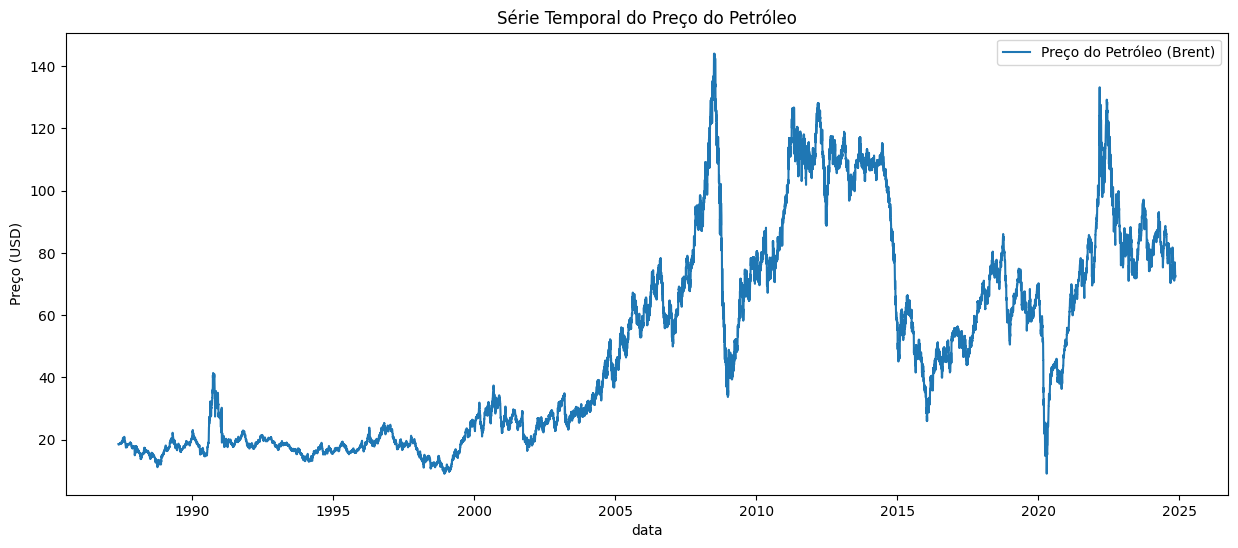

In [95]:
# Plotando o grafico de todos os anos
plt.figure(figsize=(15, 6))
plt.plot(df_ipea['preco'], label='Preço do Petróleo (Brent)')
plt.title('Série Temporal do Preço do Petróleo')
plt.xlabel('data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

In [ ]:
fechamento_20a = seasonal_decompose(df_ibovespa_20a_decom, model='additive')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (11,8))
fechamento_20a.observed.plot(ax=ax1)
fechamento_20a.trend.plot(ax=ax2)
fechamento_20a.seasonal.plot(ax=ax3)
fechamento_20a.resid.plot(ax=ax4)
plt.tight_layout()

### 6.1 - Decomposição da série período de **20 anos**

- Vamos trabalhar em cima dos ultimos 20 anos onde ouve uma maior oscilação dos valores

In [96]:
# Criando um novo df com base nos ultimos 20 anos
df_ipea_20a = df_ipea[(df_ipea.index.year >= 2004) & (df_ipea.index.year <= 2024)]
df_ipea_20a

,preco
data,
2004-01-01,30.30
2004-01-02,29.17
2004-01-03,30.10
2004-01-04,30.30
2004-01-05,32.30
...,...
2024-11-08,74.04
2024-11-09,74.04
2024-11-10,74.04


In [125]:
media_movel  = df_ipea_20a_decom = seasonal_decompose(df_ipea_20a['preco'], model='additive').trend.to_frame()
sazonalidade = df_ipea_20a_decom = seasonal_decompose(df_ipea_20a['preco'], model='additive').seasonal.to_frame()
residuo      = df_ipea_20a_decom = seasonal_decompose(df_ipea_20a['preco'], model='additive').resid.to_frame()
template = 'seaborn'

fig = make_subplots(rows = 4, cols = 1)

fig.add_trace(go.Scatter(x = df_ipea_20a.index, y = df_ipea_20a.preco, name = 'Observado', marker = dict(color = '#00008B')), row = 1, col = 1)
fig.add_trace(go.Scatter(x = media_movel.index, y = media_movel.trend, name = 'Media móvel', marker = dict(color = '#B22222')), row = 2, col = 1)
fig.add_trace(go.Scatter(x = sazonalidade.index, y = sazonalidade.seasonal, name = 'Sazonalidade', marker = dict(color = '#008000')), row = 3, col = 1)
fig.add_trace(go.Scatter(x = residuo.index, y = residuo.resid, name = 'Ruido', marker = dict(color = 'gold')), row = 4, col = 1)

fig.update_layout(
    title = {
        'text' : 'Decomposição da Série Preço do Petróleo (Brent)',
        'x':0.5,
        'xanchor': 'center'
    },
    width = 1100,
    height = 600,
    template = template
)

fig.show()

 - Uma série temporal é considerada estacionária se suas propriedades estatísticas (como média e variância) não variam com o tempo. Portanto, séries que mostram tendências ou padrões sazonais não são estacionárias. Em contraste, uma série de valores gerados aleatoriamente é estacionária, pois sua “aparência” permanece consistente ao longo do tempo.

- A decomposição da série temporal é crucial para entender o comportamento dos dados por meio dos principais componentes da análise temporal:

- **Tendência**: a direção geral que uma série temporal segue ao longo do tempo.

- **Sazonalidade**: os padrões repetitivos ou ciclos que ocorrem em intervalos regulares na série temporal.

- **Resíduos**: a variação aleatória na série temporal, que pode ser causada por fatores externos imprevisíveis ou por erros de medição.

In [113]:
# Encontrando o Maior e Menor pico
maior_valor = df_ipea_20a.loc[df_ipea_20a['preco'].idxmax()]
menor_valor = df_ipea_20a.loc[df_ipea_20a['preco'].idxmin()]

print("Maior valor:")
print(maior_valor)

print("\nMenor valor:")
print(menor_valor)

Maior valor:
preco    143.95
Name: 2008-07-03 00:00:00, dtype: float64

Menor valor:
preco    9.12
Name: 2020-04-21 00:00:00, dtype: float64


### 6.2 - Analisando o grafico da media dos meses do anos de 2008 - Maior Variação

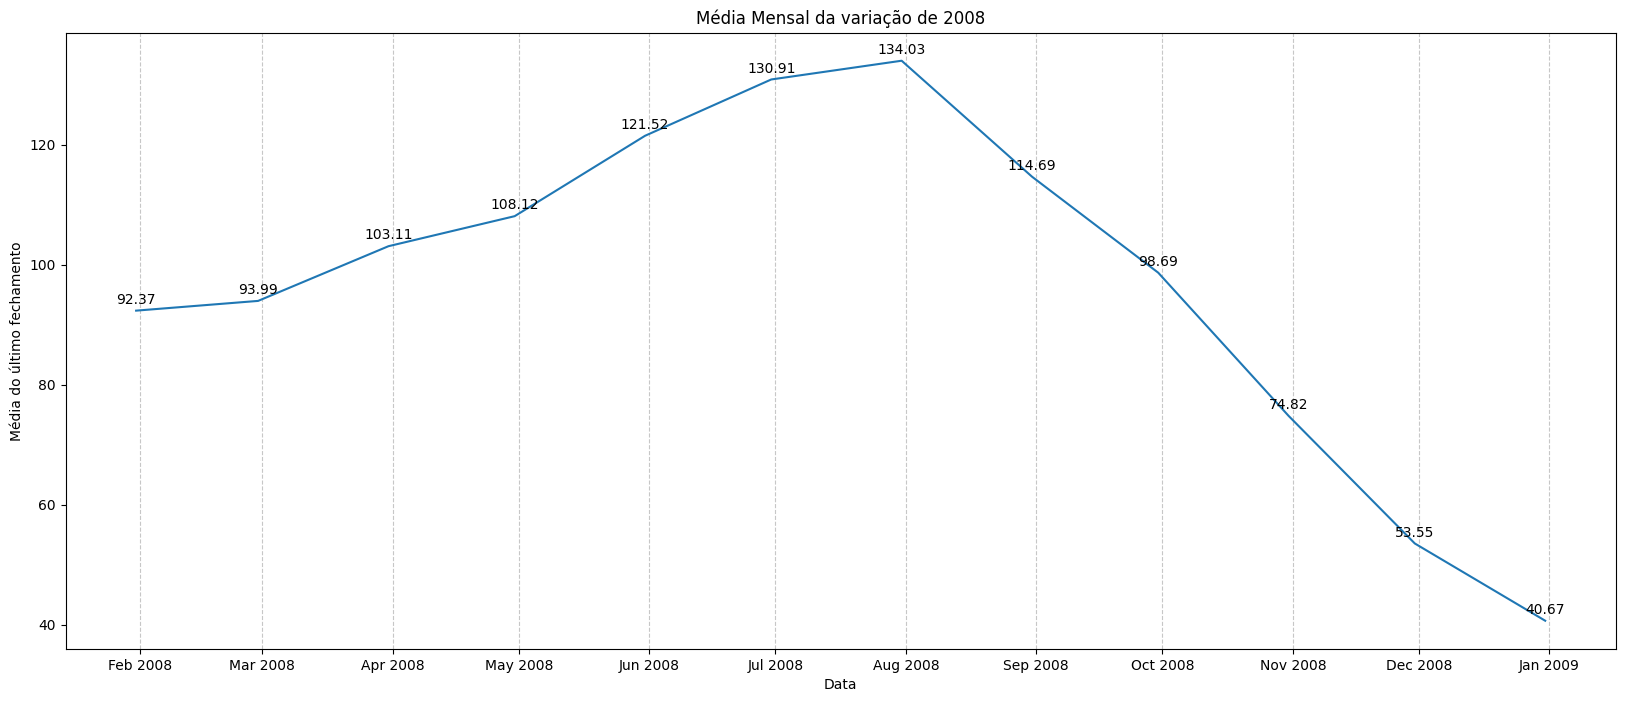

In [123]:
# DataFrame contendo apenas os dados de 2008 para analisar o maior pico
df_ipea_2008 = df_ipea_20a[df_ipea_20a.index.year == 2008]

# Resample para média mensal
df_ipea_2008_resampled_monthly = df_ipea_2008['preco'].resample('ME').mean()

# Plotar os dados mensais de 2008
plt.figure(figsize=(20, 8))
plt.plot(df_ipea_2008_resampled_monthly.index, df_ipea_2008_resampled_monthly)
plt.title('Média Mensal da variação de 2008')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_ipea_2008_resampled_monthly.index, df_ipea_2008_resampled_monthly):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')

plt.show()


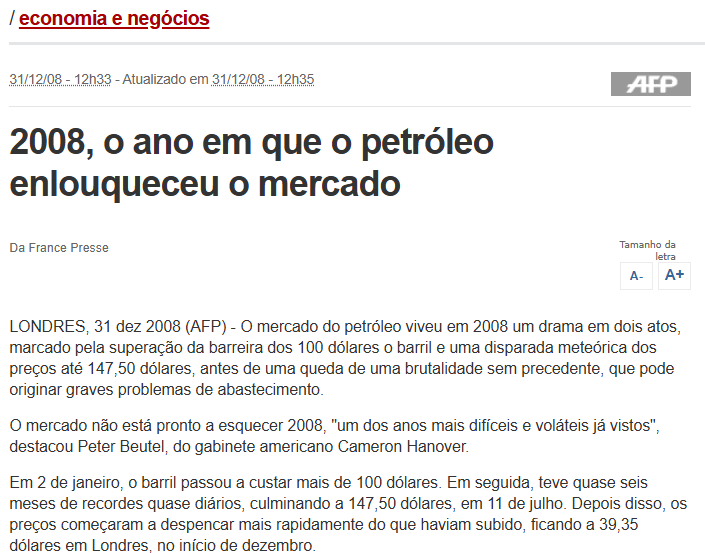




[**2008 - O ano em que o petróleo enlouqueceu o mercado**](https://g1.globo.com/Noticias/Economia_Negocios/0,,MUL940136-9356,00-O+ANO+EM+QUE+O+PETROLEO+ENLOUQUECEU+O+MERCADO.html#:~:text=LONDRES%2C%2031%20dez%202008%20%28AFP%29%20-%20O%20mercado,precedente%2C%20que%20pode%20originar%20graves%20problemas%20de%20abastecimento.
)

### 6.3 - Analisando o grafico da media dos meses do anos de 2020

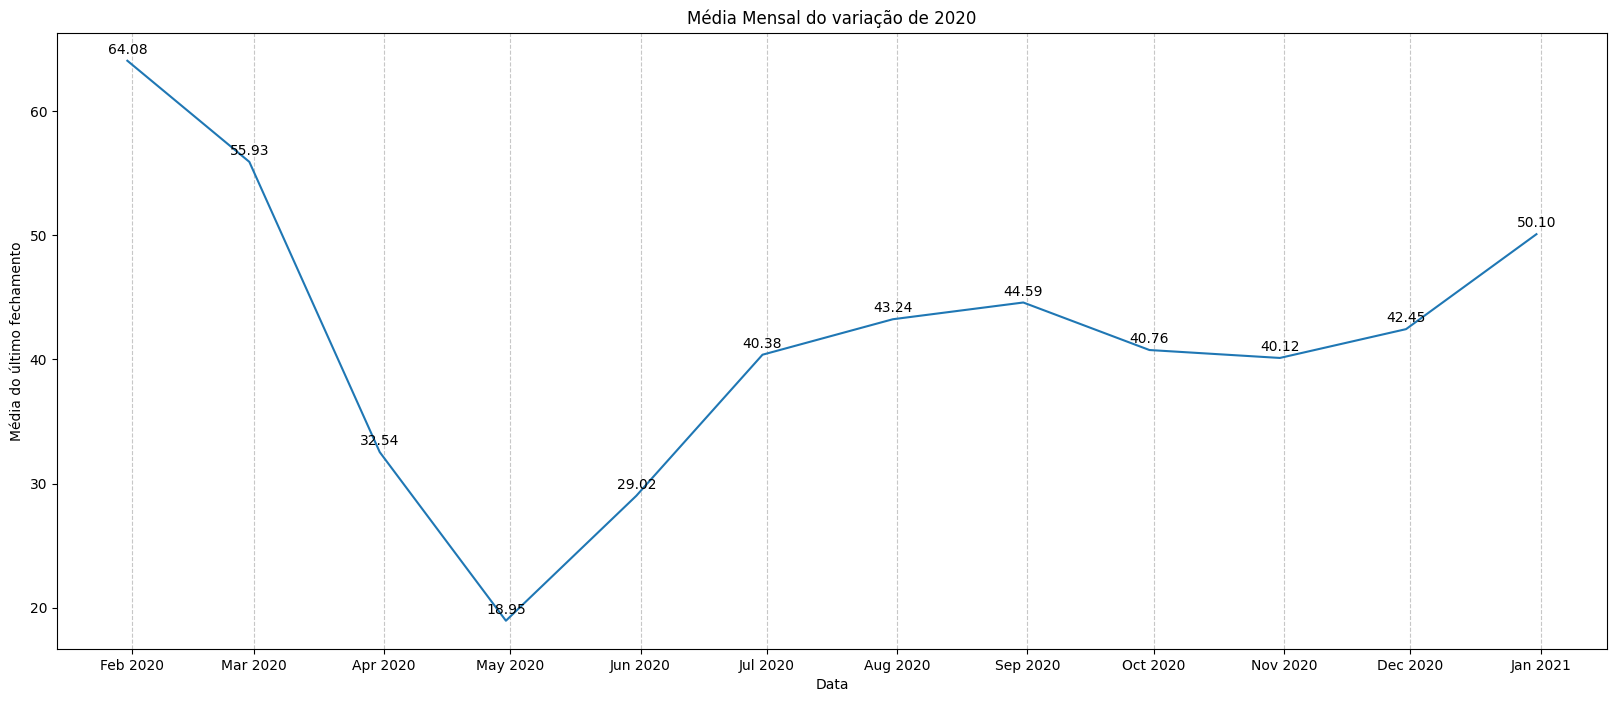

In [124]:
# DataFrame contendo apenas os dados de 2020 para analisar o menor pico
df_ipea_2020 = df_ipea_20a[df_ipea_20a.index.year == 2020]

# Resample para média mensal
df_ipea_2020_resampled_mes = df_ipea_2020['preco'].resample('ME').mean()

# Plotar os dados mensais de 2020
plt.figure(figsize=(20, 8))
plt.plot(df_ipea_2020_resampled_mes.index, df_ipea_2020_resampled_mes)
plt.title('Média Mensal do variação de 2020')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_ipea_2020_resampled_mes.index, df_ipea_2020_resampled_mes):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')

plt.show()

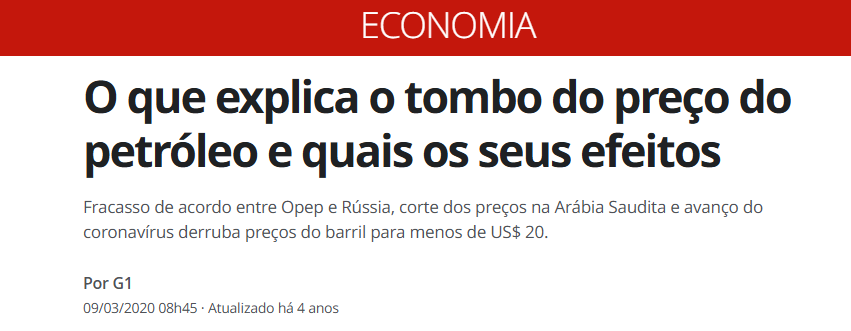


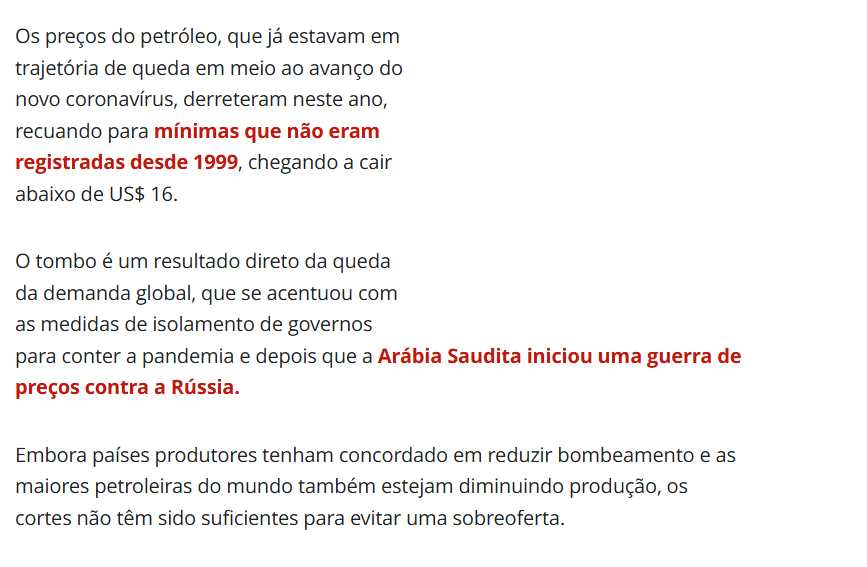

[**2020 - Covid-19 e Queda da demanda global**](https://g1.globo.com/economia/noticia/2020/03/09/o-que-explica-o-tombo-do-preco-do-petroleo-e-quais-os-seus-efeitos.ghtml)

## - Machine

In [ ]:
# 3. Modelo de Previsão - ARIMA
# Separando os dados para treino e teste
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Treinando o modelo ARIMA
model = ARIMA(train['Price'], order=(5, 1, 0))  # Ajuste os parâmetros (p, d, q)
model_fit = model.fit()

# Previsões
forecast = model_fit.forecast(steps=len(test))
test['Forecast'] = forecast

# Avaliação do Modelo
rmse = np.sqrt(mean_squared_error(test['Price'], test['Forecast']))
print(f'RMSE do Modelo: {rmse}')

# Visualizando Previsões
plt.figure(figsize=(12, 6))
plt.plot(train['Price'], label='Treino')
plt.plot(test['Price'], label='Teste')
plt.plot(test['Forecast'], label='Previsões', linestyle='--')
plt.title('Modelo ARIMA - Previsões vs Dados Reais')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

# 4. Exportando o modelo para integração no Streamlit
import pickle
with open('modelo_arima.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

print("Modelo salvo como 'modelo_arima.pkl'")
